<a href="https://colab.research.google.com/github/valeria-izvoreanu/Licenta/blob/main/licenta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Set Up

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/content/drive")
!ls

In [ ]:
!pip install transformers

In [3]:
#!pip install simpletransformers

In [ ]:
!pip install tweet-preprocessor

In [ ]:
!pip install bayesian-optimization

In [ ]:
!pip install scikeras

In [68]:
!pip install ekphrasis

In [ ]:
#!pip install imbalanced-learn

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

In [ ]:
!pip install sentence-transformers

### Loading Data

In [7]:
import pandas as pd
import os
from os.path import join

col_list = ["id", "text", "label"]

def load_dataframe(folder, name, separator, encod):
    ROOT_DIR = os.path.abspath(os.curdir)
    ROOT_DIR = "/content/drive/MyDrive/content/drive"
    path = join(ROOT_DIR, 'datasets', folder, name)
    data = pd.read_csv(path, sep=separator, encoding=encod, engine='python', usecols=col_list)
    return data

In [8]:
data_train = load_dataframe("data1", "train.csv", "¦", "utf-8")
data_test = load_dataframe("data1", "test.csv", "¦", "utf-8")
data_validation = load_dataframe("data1", "validation.csv", "¦", "utf-8")

In [ ]:
data1_train = load_dataframe("data2", "training_set_1_tweets.csv", ",", "utf-8")
data2_train = load_dataframe("data2", "training_set_1_tweets.csv", ",", "utf-8")
frames=[data1_train, data2_train]
data_train = pd.concat(frames)
data_test = load_dataframe("data2", "evaluation_set_ids.csv", ",", "utf-8")

In [ ]:
data_train = load_dataframe("data3", "data_set_ids.csv", ",", "unicode_escape")

### Preprocessing

In [9]:
from ekphrasis.classes.segmenter import Segmenter
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import string
from string import punctuation, digits
import preprocessor as p


stop = set(stopwords.words('english'))
punct = list(string.punctuation)
stop.update(punct)

def preprocess_tweets(text):
    return p.clean(text)


def remove_stopwords(text):
    final_text = []
    text = text.split()
    for i in text:
        if i not in stop:
            final_text.append(i)
    return " ".join(final_text)


def delete_digits(text):
    clean = text.translate(str.maketrans('', '', digits))
    return clean


def delete_punctuation(text):
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    clean = text.translate(translator)
    return clean


def denoise_text(text):
    text = preprocess_tweets(text)
    text = text.lower()
    text = delete_punctuation(text)
    text = delete_digits(text)
    return text


def lemm(text):
    lemmatizer = WordNetLemmatizer()
    sar_list_lemmatizer = [lemmatizer.lemmatize(word) for word in text]
    return sar_list_lemmatizer

def remove_amp(text):
  return list(filter(("amp").__ne__, text))


def get_vocab(text):
    temp = text.copy()
    vocab = text.apply(denoise_text).apply(remove_stopwords).apply(word_tokenize).apply(lemm).apply(remove_amp)
    vocab=vocab.tolist()
    for i in range(0, len(vocab)):
      vocab[i]=" ".join(vocab[i])
    return vocab


### F1-metric

In [10]:
import keras.backend as K
import tensorflow as tf
def f1_metric(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

### Threshold

Probably should find the threshold on validation then test on testing??

ROC curves should be used when there are roughly equal numbers of observations for each class.
Precision-Recall curves should be used when there is a moderate to large class imbalance.

However, ROC curves can present an overly optimistic view of an algorithm’s performance if there is a large skew in the class distribution. […] Precision-Recall (PR) curves, often used in Information Retrieval , have been cited as an alternative to ROC curves for tasks with a large skew in the class distribution.

— The Relationship Between Precision-Recall and ROC Curves, 2006.

Some go further and suggest that using a ROC curve with an imbalanced dataset might be deceptive and lead to incorrect interpretations of the model skill.

The main reason for this optimistic picture is because of the use of true negatives in the False Positive Rate in the ROC Curve and the careful avoidance of this rate in the Precision-Recall curve.

Many strategies, such as resampling the training dataset and designing customized versions of machine learning algorithms, can be utilized to handle an unbalanced classification problem.

Nonetheless, changing the decision threshold may be the easiest way to address a significant class imbalance. This strategy is frequently disregarded by practitioners and research academics alike, despite its simplicity and effectiveness.

In [30]:
from sklearn.metrics import roc_curve
import numpy as np
def roc_curve_threshold(predicted_prob, y_labels):
  fpr, tpr, thresholds = roc_curve(y_labels, predicted_prob)

  # geometric mean
  # gmeans = np.sqrt(tpr * (1-fpr))
  # # locate the index of the largest g-mean
  # ix = np.argmax(gmeans)

  # Youden’s J statistic.
  J = tpr - fpr
  ix = np.argmax(J)
  #print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
  print('Best Threshold=%f' % (thresholds[ix]))
  # plot the roc curve for the model
  plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
  plt.plot(fpr, tpr, marker='.', label='Logistic')
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  # show the plot
  plt.show()
  
  return thresholds[ix]

In [11]:
#same results, different graphs
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
def max_f1_threshold(model,predicted_prob, y_train, X_train):
  thresholds = []
  f1_scores = []
  for p in np.unique(predicted_prob):
    thresholds.append(p)
    y_pred = (predicted_prob >= p).astype(int)
    f1_scores.append(f1_score(y_train,y_pred))
  plt.scatter(thresholds,f1_scores)
  plt.xlabel("Threshold")
  plt.ylabel("Balanced accuracy")
  plt.show()
    
  return thresholds[np.argmax(f1_scores)]

def pr_curve_threshold(predicted_prob, y_labels):
  precision, recall, thresholds = precision_recall_curve(y_labels, predicted_prob)
  fscore = (2 * precision * recall) / (precision + recall)
  # locate the index of the largest f score
  ix = np.argmax(fscore)
  print('Best Threshold=%f' % (thresholds[ix]))
  no_skill = len(y_labels[y_labels==1]) / len(y_labels)
  plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
  plt.plot(recall, precision, marker='.', label='Logistic')
  # axis labels
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend()
  # show the plot
  plt.show()
  return thresholds[ix]

In [59]:
#kinda same results ca acela de mai sus
def opt_threshold_tuning(predicted_prob, y_labels):
  thresholds = np.arange(0, 1, 0.001)
  # evaluate each threshold
  scores = [f1_score(y_labels, ((predicted_prob >= t).astype(int))) for t in thresholds]
  # get best threshold
  ix = np.argmax(scores)
  print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))
  return thresholds[ix]

In [12]:
def threshold(value, threshold):
  if value>threshold:
    return 1
  else:
     return 0

### Class imbalance 

##### Random

In [79]:
def random_over_sampling(data):
    size = len(data[data['label'] == 0])
    over_sampled_data = pd.concat([data[data['label'] == 0], data[data['label'] == 1].sample(size, replace=True)])
    return over_sampled_data

def random_under_sampling(data):
    size = len(data[data['label'] == 1])
    under_sampled_data = pd.concat([data[data['label'] == 0].sample(size), data[data['label'] == 1]])
    return under_sampled_data

In [ ]:
under_random_train = random_under_sampling(data_train)

In [ ]:
under_random_train_text = get_vocab(under_random_train["text"])

In [80]:
over_random_train = random_over_sampling(data_train)

In [81]:
over_random_train_text = get_vocab(over_random_train["text"])

In [ ]:
test_text = get_vocab(data_test["text"])

##### SMOTE

try diff smote techniques https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/

In [ ]:
from imblearn.over_sampling import SMOTE
def smote_oversampling(data_text, data_label):
  oversample = SMOTE()
  X, y = oversample.fit_resample(data_text, data_label)
  return X, y

##### SMOTE + RandomUnderBalancing

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
def smote_over_undersampling(data_text, data_label):
  over = SMOTE(sampling_strategy=0.5)
  under = RandomUnderSampler(sampling_strategy=0.5)
  steps = [('o', over), ('u', under)]
  pipeline = Pipeline(steps=steps)
  X, y = pipeline.fit_resample(data_text, data_label)
  return X, y

### Tf.idf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def tf_idf_vectorizer(corpus):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus)
    return X, vectorizer

### Count vectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def count_vectorizer(corpus):
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(corpus)
    # print(X.toarray())
    return X, vectorizer

### Word2Vec

In [24]:
import gensim
from gensim.models import Word2Vec
from tensorflow.keras import models, layers, preprocessing as kprocessing
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

In [25]:
def w2v_embedding(train_text):
  ## create list of lists of unigrams
  lst_corpus = []
  for string in train_text:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) 
                for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)

  ## detect bigrams and trigrams
  bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                  delimiter=" ".encode(), min_count=30)
  bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
  trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
              delimiter=" ".encode(), min_count=30)
  trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

  nlp = Word2Vec(lst_corpus, size=300,   
            window=8, min_count=2, sg=1, iter=30)
  return nlp, lst_corpus, bigrams_detector, trigrams_detector

In [26]:
def feature_engineering(lst_corpus, train_text):
  tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
  tokenizer.fit_on_texts(lst_corpus)
  dic_vocabulary = tokenizer.word_index
  ## create sequence
  lst_corpus = []
  for string in train_text:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) 
                for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)
  lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
  ## padding sequence
  X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                      maxlen=30, padding="post", truncating="post")
  return tokenizer, dic_vocabulary, X_train

In [27]:
def test_handling(test_text,bigrams_detector, trigrams_detector, tokenizer):
  ## create list of n-grams
  lst_corpus = []
  for string in test_text:
      lst_words = string.split()
      lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                  len(lst_words), 1)]
      lst_corpus.append(lst_grams)
      
  ## detect common bigrams and trigrams using the fitted detectors
  lst_corpus = list(bigrams_detector[lst_corpus])
  lst_corpus = list(trigrams_detector[lst_corpus])
  ## text to sequence with the fitted tokenizer
  lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

  ## padding sequence
  X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=30,
              padding="post", truncating="post")
  return X_test

In [28]:
def make_embedding_matrix(dic_vocabulary, nlp):
  ## start the matrix (length of vocabulary x vector size) with all 0s
  embeddings = np.zeros((len(dic_vocabulary)+1, 300))
  for word,idx in dic_vocabulary.items():
      ## update the row with vector
      try:
          embeddings[idx] =  nlp[word]
      ## if word not in model then skip and the row stays all 0s
      except:
          pass
  return embeddings

In [29]:
def rn_w2v_model(embeddings):
  ## input
  x_in = layers.Input(shape=(30,))
  ## embedding
  x = layers.Embedding(input_dim=embeddings.shape[0],  
                      output_dim=embeddings.shape[1], 
                      weights=[embeddings],
                      input_length=30, trainable=False)(x_in)
  ## 2 layers of bidirectional lstm
  x = layers.Bidirectional(layers.LSTM(units=30, dropout=0.2, 
                          return_sequences=True))(x)
  x = layers.Bidirectional(layers.LSTM(units=30, dropout=0.2))(x)
  ## final dense layers
  x = layers.Dense(64, activation='relu')(x)
  y_out = layers.Dense(1, activation='sigmoid')(x)
  ## compile
  model = models.Model(x_in, y_out)
  model.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=[f1_metric])

  model.summary()
  return model

In [53]:
def w2v_train(model, y_train, X_train, X_valid, y_valid):
  dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
  # inverse_dic = {v:k for k,v in dic_y_mapping.items()}
  y_train = np.array(y_train)
  ## train
  # training = model.fit(x=X_train, y=y_train, batch_size=256, 
  #                     epochs=20, shuffle=True, verbose=0, 
  #                     validation_data=(X_valid, y_valid))
  class_weight={
      0:1.,
      1:9.
  }
  early_stopping = EarlyStopping(
      min_delta=0.001, # minimium amount of change to count as an improvement
      patience=10, # how many epochs to wait before stopping
      restore_best_weights=True,
  )
  #train with weights
  training = model.fit(x=X_train, y=y_train, batch_size=32, 
                      epochs=30, shuffle=True, verbose=1, callbacks=[early_stopping],
                      validation_data=(X_valid, y_valid), class_weight=class_weight)
  ## plot loss and accuracy
  metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
  fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
  ax[0].set(title="Training")
  ax11 = ax[0].twinx()
  ax[0].plot(training.history['loss'], color='black')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss', color='black')
  for metric in metrics:
      ax11.plot(training.history[metric], label=metric)
  ax11.set_ylabel("Score", color='steelblue')
  ax11.legend()
  ax[1].set(title="Validation")
  ax22 = ax[1].twinx()
  ax[1].plot(training.history['val_loss'], color='black')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss', color='black')
  for metric in metrics:
      ax22.plot(training.history['val_'+metric], label=metric)
  ax22.set_ylabel("Score", color="steelblue")
  plt.show()
  return model, dic_y_mapping

In [31]:
def w2v_test(model, X_test, dic_y_mapping, y_test):
  predicted_prob = model.predict(X_test)
  #opt_threshold = roc_curve_threshold(predicted_prob, y_test)
  opt_threshold = pr_curve_threshold(predicted_prob, y_test)
  predicted = [threshold(pred, opt_threshold) for pred in 
              predicted_prob]
  accuracy = metrics.accuracy_score(y_test, predicted)
  #auc = metrics.roc_auc_score(y_test, predicted_prob, multi_class="ovo")
  print("Accuracy:",  round(accuracy,2))
  #print("Auc:", round(auc,2))
  print("Detail:")
  print(metrics.classification_report(y_test, predicted))

In [45]:
train_text = get_vocab(data_train["text"])
nlp, lst_corpus, bigrams_detector, trigrams_detector = w2v_embedding(train_text)

In [46]:
tokenizer, dic_vocabulary, X_train = feature_engineering(lst_corpus, train_text)

In [47]:
test_text = get_vocab(data_test["text"])
X_test = test_handling(test_text,bigrams_detector, trigrams_detector, tokenizer)

In [48]:
x_valid = test_handling(get_vocab(data_validation["text"]),bigrams_detector, trigrams_detector, tokenizer)

In [49]:
embeddings=make_embedding_matrix(dic_vocabulary, nlp)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [51]:
w2v_model = rn_w2v_model(embeddings)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 30, 300)           3382200   
                                                                 
 bidirectional_2 (Bidirectio  (None, 30, 60)           79440     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 60)               21840     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 64)                3904      
                                                                 
 dense_5 (Dense)             (None, 1)                 65  

Epoch 1/30
252/252 [==============================] - 9s 19ms/step - loss: 0.9756 - f1_metric: 0.3166 - val_loss: 0.4563 - val_f1_metric: 0.2902
Epoch 2/30
252/252 [==============================] - 3s 13ms/step - loss: 0.8370 - f1_metric: 0.3923 - val_loss: 0.3885 - val_f1_metric: 0.3178
Epoch 3/30
252/252 [==============================] - 3s 13ms/step - loss: 0.7861 - f1_metric: 0.4015 - val_loss: 0.3962 - val_f1_metric: 0.2946
Epoch 4/30
252/252 [==============================] - 3s 13ms/step - loss: 0.7436 - f1_metric: 0.4269 - val_loss: 0.3513 - val_f1_metric: 0.3078
Epoch 5/30
252/252 [==============================] - 3s 13ms/step - loss: 0.7029 - f1_metric: 0.4404 - val_loss: 0.3954 - val_f1_metric: 0.3108
Epoch 6/30
252/252 [==============================] - 3s 13ms/step - loss: 0.6576 - f1_metric: 0.4574 - val_loss: 0.2731 - val_f1_metric: 0.3283
Epoch 7/30
252/252 [==============================] - 3s 13ms/step - loss: 0.6067 - f1_metric: 0.4810 - val_loss: 0.3826 - val_f1_

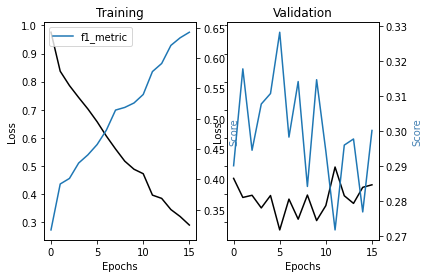

In [54]:
w2v_model_trained, y_mapping = w2v_train(w2v_model, data_train["label"], X_train, x_valid, data_validation["label"])

Best Threshold=0.438600


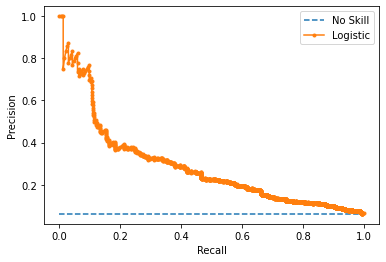

Accuracy: 0.9
Detail:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      3585
           1       0.29      0.41      0.34       234

    accuracy                           0.90      3819
   macro avg       0.62      0.67      0.64      3819
weighted avg       0.92      0.90      0.91      3819



In [55]:
w2v_test(w2v_model_trained, X_test, y_mapping, data_test["label"])

In [83]:
tokenizer, dic_vocabulary, X_train = feature_engineering(lst_corpus, over_random_train_text)

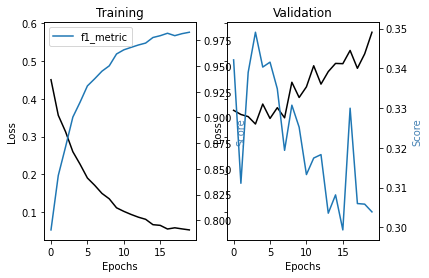

In [84]:
w2v_model_trained, y_mapping = w2v_train(w2v_model, over_random_train["label"], X_train, x_valid, data_validation["label"])

Best Threshold=0.190268


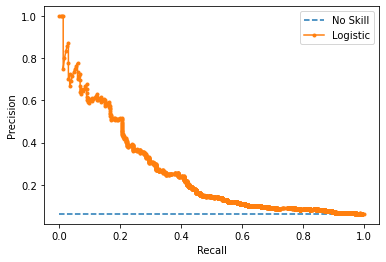

Accuracy: 0.92
Detail:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      3585
           1       0.34      0.28      0.31       234

    accuracy                           0.92      3819
   macro avg       0.65      0.62      0.63      3819
weighted avg       0.92      0.92      0.92      3819



In [85]:
w2v_test(w2v_model_trained, X_test, y_mapping, data_test["label"])

In [ ]:
w2v_model_trained.save("w2v_rn_over_random")

In [ ]:
tokenizer, dic_vocabulary, X_train = feature_engineering(lst_corpus, under_random_train_text)

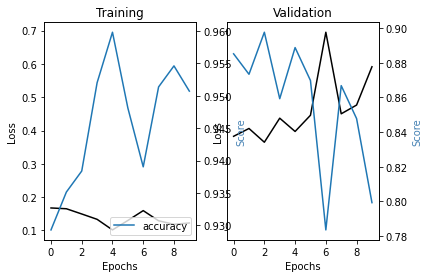

In [ ]:
w2v_model_trained, y_mapping = w2v_train(w2v_model, under_random_train["label"], X_train, x_valid, data_validation["label"])

In [ ]:
w2v_test(w2v_model_trained, X_test, y_mapping, data_test["label"])

Accuracy: 0.84
Detail:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      3585
           1       0.18      0.44      0.26       234

    accuracy                           0.84      3819
   macro avg       0.57      0.66      0.59      3819
weighted avg       0.91      0.84      0.87      3819



In [ ]:
w2v_model_trained.save("w2v_rn_under_random")

Smote

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn import metrics

In [ ]:
def naive_Bayes_Classif(x_train, x_test, y_train, y_test):
  MNB = BernoulliNB()
  
  MNB.fit(x_train, y_train)
  predicted = MNB.predict(x_test)
  print(metrics.classification_report(y_test, predicted))


##### Count Vectorizer

In [ ]:
train_text = get_vocab(data_train["text"])
cv_train, cv = count_vectorizer(train_text)
test_text = get_vocab(data_test["text"])
cv_test =  cv.transform(test_text)

In [ ]:
from collections import Counter

In [ ]:
over_smote_train_text, over_smote_train_label = smote_oversampling(cv_train,data_train["label"])

Counter({1: 7293, 0: 7293})


In [ ]:
naive_Bayes_Classif(over_smote_train_text, cv_test, over_smote_train_label, data_test["label"])

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      3585
           1       0.09      0.20      0.12       234

    accuracy                           0.82      3819
   macro avg       0.51      0.53      0.51      3819
weighted avg       0.89      0.82      0.85      3819



In [ ]:
over_smote_under_train_text, over_smote_under_train_label = smote_over_undersampling(cv_train,data_train["label"])
print(Counter(over_smote_under_train_label))

Counter({0: 7292, 1: 3646})


In [ ]:
naive_Bayes_Classif(over_smote_under_train_text, cv_test, over_smote_under_train_label, data_test["label"])

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      3585
           1       0.13      0.20      0.16       234

    accuracy                           0.87      3819
   macro avg       0.54      0.56      0.54      3819
weighted avg       0.90      0.87      0.88      3819



In [ ]:
cv_train, cv = count_vectorizer(under_random_train_text)
cv_test =  cv.transform(test_text)
naive_Bayes_Classif(cv_train, cv_test, under_random_train["label"], data_test["label"])

              precision    recall  f1-score   support

           0       0.97      0.75      0.85      3585
           1       0.16      0.70      0.25       234

    accuracy                           0.75      3819
   macro avg       0.57      0.73      0.55      3819
weighted avg       0.92      0.75      0.81      3819



In [ ]:
cv_train, cv = count_vectorizer(over_random_train_text)
cv_test =  cv.transform(test_text)
naive_Bayes_Classif(cv_train, cv_test, over_random_train["label"], data_test["label"])

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      3585
           1       0.25      0.51      0.33       234

    accuracy                           0.87      3819
   macro avg       0.61      0.70      0.63      3819
weighted avg       0.92      0.87      0.89      3819



##### Tf.idf

In [ ]:
train_text = get_vocab(data_train["text"])
tf_train, tf = tf_idf_vectorizer(train_text)
test_text = get_vocab(data_test["text"])
tf_test =  tf.transform(test_text)

In [ ]:
over_smote_train_text, over_smote_train_label = smote_oversampling(tf_train,data_train["label"])
naive_Bayes_Classif(over_smote_train_text, tf_test, over_smote_train_label, data_test["label"])

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3585
           1       0.36      0.31      0.33       234

    accuracy                           0.92      3819
   macro avg       0.66      0.64      0.65      3819
weighted avg       0.92      0.92      0.92      3819



In [ ]:
over_smote_under_train_text, over_smote_under_train_label = smote_over_undersampling(tf_train,data_train["label"])
naive_Bayes_Classif(over_smote_under_train_text, tf_test, over_smote_under_train_label, data_test["label"])

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      3585
           1       0.40      0.21      0.28       234

    accuracy                           0.93      3819
   macro avg       0.68      0.59      0.62      3819
weighted avg       0.92      0.93      0.92      3819



In [ ]:
tf_train, tf = tf_idf_vectorizer(under_random_train_text)
tf_test =  tf.transform(test_text)
naive_Bayes_Classif(tf_train, tf_test, under_random_train["label"], data_test["label"])

              precision    recall  f1-score   support

           0       0.98      0.77      0.86      3585
           1       0.17      0.71      0.27       234

    accuracy                           0.76      3819
   macro avg       0.57      0.74      0.56      3819
weighted avg       0.93      0.76      0.82      3819



In [ ]:
tf_train, tf = tf_idf_vectorizer(over_random_train_text)
tf_test =  tf.transform(test_text)
naive_Bayes_Classif(tf_train, tf_test, over_random_train["label"], data_test["label"])

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      3585
           1       0.25      0.50      0.33       234

    accuracy                           0.88      3819
   macro avg       0.61      0.70      0.63      3819
weighted avg       0.92      0.88      0.90      3819



### BERT (Sentence Transformers)

In [13]:
from sentence_transformers import SentenceTransformer
from keras.models import Sequential
from keras.initializers import GlorotNormal
from keras.layers import Dense, Dropout, Bidirectional, LSTM, Embedding, Input, BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from keras import models
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.callbacks import LearningRateScheduler

In [62]:
def sentence_transformers_embeddings(texts):
  model = SentenceTransformer("all-mpnet-base-v2")
  #model = SentenceTransformer("all-distilroberta-v1")

  #Sentences are encoded by calling model.encode()
  embeddings = model.encode(texts)

  return embeddings

In [15]:
def rn_bert_sent_transf_model(embeddings, y_train):
  input_size = len(embeddings[0])
  model = Sequential()
  initializer = GlorotNormal()
 
  model.add(Dense(96, input_shape=(input_size, ), activation="relu", kernel_initializer=initializer))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid', kernel_initializer=initializer))
  model.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=[f1_metric])
  model.summary()
  return model

In [80]:
def bert_sent_transf_train(model, y_train, X_train, X_valid, y_valid):
  dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
  #y_train = tf.one_hot(y_train, depth=2).numpy()
  
  #X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train)
  # y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
  # y_valid = np.asarray(y_valid).astype('float32').reshape((-1,1))
  #y_valid = tf.one_hot(y_valid, depth=2).numpy()
  #print(y_valid)
  early_stopping = EarlyStopping(
      min_delta=0.001, # minimium amount of change to count as an improvement
      patience=10, # how many epochs to wait before stopping
      restore_best_weights=True,
  )
  ## train
  training = model.fit(x=X_train, y=y_train, batch_size=32, 
                      epochs=30, shuffle=True, verbose=1, callbacks=[early_stopping],
                      validation_data=(X_valid, y_valid))
  #train with weights
  # class_weight={
  #     0:1.,
  #     1:9.
  # }
  # training = model.fit(x=X_train, y=y_train, batch_size=32, 
  #                     epochs=30, shuffle=True, verbose=1, callbacks=[early_stopping],
  #                     validation_data=(X_valid, y_valid), class_weight=class_weight)
  ## plot loss and accuracy
  metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
  fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
  ax[0].set(title="Training")
  ax11 = ax[0].twinx()
  ax[0].plot(training.history['loss'], color='black')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss', color='black')
  for metric in metrics:
      ax11.plot(training.history[metric], label=metric)
  ax11.set_ylabel("Score", color='steelblue')
  ax11.legend()
  ax[1].set(title="Validation")
  ax22 = ax[1].twinx()
  ax[1].plot(training.history['val_loss'], color='black')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss', color='black')
  for metric in metrics:
      ax22.plot(training.history['val_'+metric], label=metric)
  ax22.set_ylabel("Score", color="steelblue")
  plt.show()
  return model, dic_y_mapping

In [104]:
def bert_sent_transf_test(model, X_test, dic_y_mapping, y_test, X_valid, y_valid):
  predicted_prob = model.predict(X_test)
  # opt_threshold = 0.5
  # opt_threshold = roc_curve_threshold(predicted_prob, y_test)
  opt_threshold = max_f1_threshold(model,predicted_prob, y_test, X_test)
  # opt_threshold = pr_curve_threshold(predicted_prob, y_test)
  #opt_threshold = pr_curve_threshold(model.predict(X_valid), y_valid)
  # opt_threshold = opt_threshold_tuning(predicted_prob, y_test)
  predicted = [threshold(pred, opt_threshold) for pred in 
              predicted_prob]
  accuracy = metrics.accuracy_score(y_test, predicted)
  print("Accuracy:",  round(accuracy,2))
  print(metrics.classification_report(y_test, predicted))

In [125]:
text_train = get_vocab(data_train["text"])
embeddings = sentence_transformers_embeddings(text_train)

In [ ]:
embeddings_smote_text, embeddings_smote_labels  = smote_oversampling(embeddings, data_train["label"])

In [ ]:
#bert_sentence_transformer_model = rn_bert_sent_transf_model(embeddings_smote_text, embeddings_smote_labels)

In [75]:
bert_sentence_transformer_model = rn_bert_sent_transf_model(embeddings, data_train["label"])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 96)                73824     
                                                                 
 dropout_3 (Dropout)         (None, 96)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 97        
                                                                 
Total params: 73,921
Trainable params: 73,921
Non-trainable params: 0
_________________________________________________________________


In [126]:
text_valid = get_vocab(data_validation["text"])
embeddings_valid = sentence_transformers_embeddings(text_valid)

Epoch 1/30
252/252 [==============================] - 1s 4ms/step - loss: 0.1097 - f1_metric: 0.7068 - val_loss: 0.2117 - val_f1_metric: 0.3394
Epoch 2/30
252/252 [==============================] - 1s 4ms/step - loss: 0.0979 - f1_metric: 0.7219 - val_loss: 0.2125 - val_f1_metric: 0.3109
Epoch 3/30
252/252 [==============================] - 1s 4ms/step - loss: 0.0939 - f1_metric: 0.7393 - val_loss: 0.2115 - val_f1_metric: 0.3182
Epoch 4/30
252/252 [==============================] - 1s 4ms/step - loss: 0.0919 - f1_metric: 0.7666 - val_loss: 0.2110 - val_f1_metric: 0.3163
Epoch 5/30
252/252 [==============================] - 1s 4ms/step - loss: 0.0903 - f1_metric: 0.7535 - val_loss: 0.2138 - val_f1_metric: 0.3539
Epoch 6/30
252/252 [==============================] - 1s 4ms/step - loss: 0.0875 - f1_metric: 0.7567 - val_loss: 0.2132 - val_f1_metric: 0.3301
Epoch 7/30
252/252 [==============================] - 1s 3ms/step - loss: 0.0859 - f1_metric: 0.7716 - val_loss: 0.2139 - val_f1_metric:

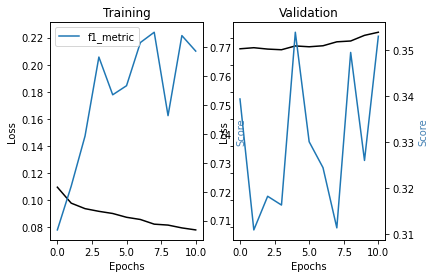

In [81]:
trained_bert_sent_transf_model, dic_y_mapping = bert_sent_transf_train(bert_sentence_transformer_model, data_train["label"], embeddings, embeddings_valid, data_validation["label"])

In [127]:
text_test = get_vocab(data_test["text"])
embeddings_test = sentence_transformers_embeddings(text_test)

In [ ]:
predicted_prob = trained_bert_sent_transf_model.predict(embeddings_test)
print(predicted_prob)

Best Threshold=0.326622


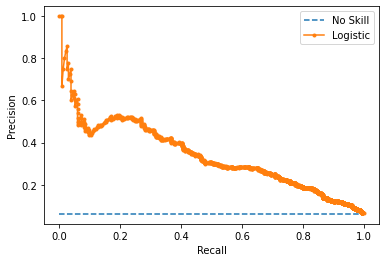

Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3585
           1       0.40      0.40      0.40       234

    accuracy                           0.93      3819
   macro avg       0.68      0.68      0.68      3819
weighted avg       0.93      0.93      0.93      3819



In [82]:
bert_sent_transf_test(trained_bert_sent_transf_model, embeddings_test, dic_y_mapping, data_test["label"], embeddings_valid, data_validation["label"])

In [60]:
#at first i used 0.5 as a threshold, but since the classes are so imbalanced, computing a more suited threshold was necesary
bert_sent_transf_test(trained_bert_sent_transf_model, embeddings_valid, dic_y_mapping, data_validation["label"])

Threshold=0.233, F-Score=0.43830
Accuracy: 0.91
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      2849
           1       0.38      0.52      0.44       200

    accuracy                           0.91      3049
   macro avg       0.67      0.73      0.70      3049
weighted avg       0.93      0.91      0.92      3049



Best Threshold=0.247300


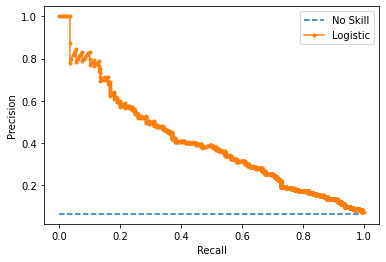

Accuracy: 0.92
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      2849
           1       0.39      0.49      0.44       200

    accuracy                           0.92      3049
   macro avg       0.68      0.72      0.70      3049
weighted avg       0.93      0.92      0.92      3049



In [54]:
bert_sent_transf_test(trained_bert_sent_transf_model, embeddings_valid, dic_y_mapping, data_validation["label"])

In [ ]:
import tensorflow as tf
Labels = tf.one_hot(data_validation["label"], depth=2)
print(Labels)

### RNN fine tuning

try with w2v and others

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scikeras.wrappers import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from keras.layers import LeakyReLU
import tensorflow as tf

In [83]:
def nn_cl_bo(neurons, activation, optimizer, learning_rate,  batch_size, epochs):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':tf.keras.optimizers.Adam(learning_rate=learning_rate), 'SGD':tf.keras.optimizers.SGD(learning_rate=learning_rate),
                 'RMSprop':tf.keras.optimizers.RMSprop(learning_rate=learning_rate), 'Adadelta':tf.keras.optimizers.Adadelta(learning_rate=learning_rate),
                 'Adagrad':tf.keras.optimizers.Adagrad(learning_rate=learning_rate), 'Adamax':tf.keras.optimizers.Adamax(learning_rate=learning_rate),
                 'Nadam':tf.keras.optimizers.Nadam(learning_rate=learning_rate), 'Ftrl':tf.keras.optimizers.Ftrl(learning_rate=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential']
    neurons = round(neurons)
    activation = activationL[round(activation)]
    batch_size = round(batch_size)
    epochs = round(epochs)
    def nn_cl_fun():
        opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
        nn = Sequential()
        nn.add(Dense(neurons, input_dim=len(embeddings[0]), activation=activation))
        nn.add(Dense(neurons, activation=activation))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=opt, metrics=[f1_metric])
        return nn
    es = EarlyStopping(monitor='f1_metric', mode='max', verbose=0, patience=20)
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size,
                         verbose=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    score = cross_val_score(nn, embeddings, data_train["label"], scoring=make_scorer(f1_score), cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score

In [88]:
def nn_cl_bo2(neurons, activation, optimizer, learning_rate, batch_size, epochs,
              layers1, layers2, normalization, dropout, dropout_rate):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':tf.keras.optimizers.Adam(learning_rate=learning_rate), 'SGD':tf.keras.optimizers.SGD(learning_rate=learning_rate),
                 'RMSprop':tf.keras.optimizers.RMSprop(learning_rate=learning_rate), 'Adadelta':tf.keras.optimizers.Adadelta(learning_rate=learning_rate),
                 'Adagrad':tf.keras.optimizers.Adagrad(learning_rate=learning_rate), 'Adamax':tf.keras.optimizers.Adamax(learning_rate=learning_rate),
                 'Nadam':tf.keras.optimizers.Nadam(learning_rate=learning_rate), 'Ftrl':tf.keras.optimizers.Ftrl(learning_rate=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential']
    neurons = round(neurons)
    activation = activationL[round(activation)]
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    batch_size = round(batch_size)
    epochs = round(epochs)
    layers1 = round(layers1)
    layers2 = round(layers2)
    def nn_cl_fun():
        nn = Sequential()
        nn.add(Dense(neurons, input_dim=len(embeddings[0]), activation=activation))
        if normalization > 0.5:
            nn.add(BatchNormalization())
        for i in range(layers1):
            nn.add(Dense(neurons, activation=activation))
        if dropout > 0.5:
            nn.add(Dropout(dropout_rate, seed=123))
        for i in range(layers2):
            nn.add(Dense(neurons, activation=activation))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f1_metric])
        return nn
    es = EarlyStopping(monitor='f1_metric', mode='max', verbose=0, patience=20)
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size, verbose=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    score = cross_val_score(nn, embeddings, data_train["label"], scoring=make_scorer(f1_score), cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score

In [ ]:
score_f1 = make_scorer(f1_score)
params_nn ={
    'neurons': (10, 100),
    'activation':(0, 7),
    'optimizer':(0,7),
    'learning_rate':(0.01, 1),
    'batch_size':(200, 1000),
    'epochs':(20, 100)
}
# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_cl_bo, params_nn, random_state=111)
nn_bo.maximize(init_points=25, n_iter=4)

In [85]:
params_nn_ = nn_bo.max['params']
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU,'relu']
params_nn_['activation'] = activationL[round(params_nn_['activation'])]
print(params_nn_)

{'activation': 'tanh', 'batch_size': 851.0135336291902, 'epochs': 53.7054301919375, 'learning_rate': 0.037173480215022196, 'neurons': 50.872297884262295, 'optimizer': 0.7372825972056519}


In [ ]:
params_nn2 ={
    'neurons': (10, 100),
    'activation':(0, 7),
    'optimizer':(0,7),
    'learning_rate':(0.01, 1),
    'batch_size':(200, 1000),
    'epochs':(20, 100),
    'layers1':(1,3),
    'layers2':(1,3),
    'normalization':(0,1),
    'dropout':(0,1),
    'dropout_rate':(0,0.3)
}
# Run Bayesian Optimization
nn_bo_l = BayesianOptimization(nn_cl_bo2, params_nn2, random_state=111)
nn_bo_l.maximize(init_points=25, n_iter=4)

In [91]:
params_nn_ = nn_bo_l.max['params']
learning_rate = params_nn_['learning_rate']
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU,'relu']
params_nn_['activation'] = activationL[round(params_nn_['activation'])]
params_nn_['batch_size'] = round(params_nn_['batch_size'])
params_nn_['epochs'] = round(params_nn_['epochs'])
params_nn_['layers1'] = round(params_nn_['layers1'])
params_nn_['layers2'] = round(params_nn_['layers2'])
params_nn_['neurons'] = round(params_nn_['neurons'])
optimizerL = ['Adam', 'SGD', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','Adam']
optimizerD= {'Adam':tf.keras.optimizers.Adam(learning_rate=learning_rate), 'SGD':tf.keras.optimizers.SGD(learning_rate=learning_rate),
                 'RMSprop':tf.keras.optimizers.RMSprop(learning_rate=learning_rate), 'Adadelta':tf.keras.optimizers.Adadelta(learning_rate=learning_rate),
                 'Adagrad':tf.keras.optimizers.Adagrad(learning_rate=learning_rate), 'Adamax':tf.keras.optimizers.Adamax(learning_rate=learning_rate),
                 'Nadam':tf.keras.optimizers.Nadam(learning_rate=learning_rate), 'Ftrl':tf.keras.optimizers.Ftrl(learning_rate=learning_rate)}
params_nn_['optimizer'] = optimizerD[optimizerL[round(params_nn_['optimizer'])]]
print(params_nn_)

{'activation': 'relu', 'batch_size': 242, 'dropout': 0.1279608146375314, 'dropout_rate': 0.010014947837176436, 'epochs': 38, 'layers1': 2, 'layers2': 1, 'learning_rate': 0.18755133602737314, 'neurons': 23, 'normalization': 0.6830131255680931, 'optimizer': <keras.optimizer_v2.adadelta.Adadelta object at 0x7f5d481d2690>}


In [128]:
def nn_cl_fun():
  input_size = len(embeddings[0])
  initializer = GlorotNormal()
  
  nn = Sequential()
  nn.add(Dense(params_nn_['neurons'], input_shape=(input_size, ), activation="relu", kernel_initializer=initializer))
  if params_nn_['normalization'] > 0.5:
    nn.add(BatchNormalization())
  for i in range(params_nn_['layers1']):
    nn.add(Dense(params_nn_['neurons'], activation=params_nn_['activation']))
  if params_nn_['dropout'] > 0.5:
    nn.add(Dropout(params_nn_['dropout_rate'], seed=123))
  for i in range(params_nn_['layers2']):
    nn.add(Dense(params_nn_['neurons'], activation=params_nn_['activation']))
  nn.add(Dense(1, activation='sigmoid'))
  nn.compile(loss='binary_crossentropy', optimizer=params_nn_['optimizer'], metrics=[f1_metric])
  nn.summary()
  return nn

In [123]:
def bert_sent_transf_test(model, X_test, dic_y_mapping, y_test, X_valid, y_valid):
  predicted_prob = model.predict(X_test)
  print(predicted_prob)
  # opt_threshold = 0.5
  # opt_threshold = roc_curve_threshold(predicted_prob, y_test)
  #opt_threshold = max_f1_threshold(model,predicted_prob, y_test, X_test)
  #opt_threshold = pr_curve_threshold(predicted_prob, y_test)
  opt_threshold = pr_curve_threshold(model.predict(X_valid), y_valid)
  # opt_threshold = opt_threshold_tuning(predicted_prob, y_test)
  predicted = [threshold(pred, opt_threshold) for pred in 
              predicted_prob]
  accuracy = metrics.accuracy_score(y_test, predicted)
  print("Accuracy:",  round(accuracy,2))
  print(metrics.classification_report(y_test, predicted))

In [118]:
def training_rn(X_train, y_train, X_valid, y_valid):
  es = EarlyStopping(monitor='f1_metric', mode='max', verbose=0, patience=20)
  # nn = KerasClassifier(build_fn=nn_cl_fun, epochs=params_nn_['epochs'], batch_size=params_nn_['batch_size'],
  #                           verbose=0)
  nn=nn_cl_fun()
  # nn.fit(embeddings, data_train["label"], validation_data=(embeddings_valid, data_validation["label"]), verbose=1)
  training = nn.fit(x=X_train, y=y_train, batch_size=32, 
                        epochs=30, shuffle=True, verbose=1, callbacks=[es],
                        validation_data=(X_valid, y_valid))

  metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
  fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
  ax[0].set(title="Training")
  ax11 = ax[0].twinx()
  ax[0].plot(training.history['loss'], color='black')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss', color='black')
  for metric in metrics:
      ax11.plot(training.history[metric], label=metric)
  ax11.set_ylabel("Score", color='steelblue')
  ax11.legend()
  ax[1].set(title="Validation")
  ax22 = ax[1].twinx()
  ax[1].plot(training.history['val_loss'], color='black')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss', color='black')
  for metric in metrics:
      ax22.plot(training.history['val_'+metric], label=metric)
  ax22.set_ylabel("Score", color="steelblue")
  plt.show()
  return nn, dic_y_mapping

Model: "sequential_362"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1677 (Dense)          (None, 23)                17687     
                                                                 
 batch_normalization_96 (Bat  (None, 23)               92        
 chNormalization)                                                
                                                                 
 dense_1678 (Dense)          (None, 23)                552       
                                                                 
 dense_1679 (Dense)          (None, 23)                552       
                                                                 
 dense_1680 (Dense)          (None, 23)                552       
                                                                 
 dense_1681 (Dense)          (None, 1)                 24        
                                                    

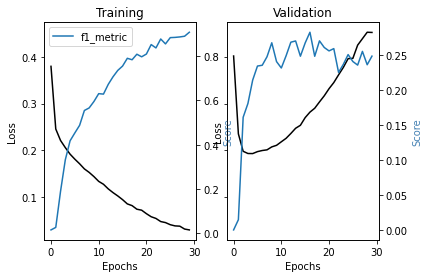

In [129]:
model, dic_y_mapping = training_rn(embeddings, data_train["label"], embeddings_valid, data_validation["label"])

[[4.27264091e-08]
 [1.15390785e-05]
 [7.72993099e-06]
 ...
 [1.44099076e-05]
 [3.86162974e-05]
 [4.51575443e-06]]
Best Threshold=0.454818


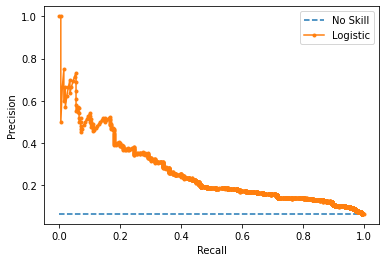

Accuracy: 0.92
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3585
           1       0.32      0.24      0.27       234

    accuracy                           0.92      3819
   macro avg       0.63      0.60      0.62      3819
weighted avg       0.91      0.92      0.92      3819



In [130]:
bert_sent_transf_test(model, embeddings_test, dic_y_mapping, data_test["label"], embeddings_valid, data_validation["label"])

### Plotting

In [ ]:
#word clouds

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def tweet_distribution(count_adr, count_noadr, index_names, fig_name):
  plotdata = pd.DataFrame({
    "ADR":count_adr,
    "no ADR":count_noadr},
    index=index_names)

  plotdata.plot(kind="bar",figsize=(15, 8))
  plt.title("Tweets distribution")
  plt.xlabel("Set")
  plt.ylabel("Tweets")
  plt.savefig(fig_name)

In [ ]:
train_labels = data_train["label"].tolist()
test_labels = data_test["label"].tolist()
valid_labels = data_validation["label"].tolist()

tweet_distribution([train_labels.count(1),test_labels.count(1),valid_labels.count(1)], [train_labels.count(0),test_labels.count(0),valid_labels.count(0)],["Train", "Test", "Validation"],"dataset1_distribution.png")


In [ ]:
train_labels = data_train["label"].tolist()
test_labels = data_test["label"].tolist()

tweet_distribution([train_labels.count(1),test_labels.count(1)], [train_labels.count(0),test_labels.count(0)],["Train", "Test"],"dataset2_distribution.png")


In [ ]:
train_labels = data_train["label"].tolist()

tweet_distribution([train_labels.count(1)], [train_labels.count(0)],["Train"],"dataset3_distribution.png")

### Word2Vec 2

In [ ]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import logging  # Setting up the loggings to monitor gensim
from gensim.models import Word2Vec
import numpy as np
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [ ]:
def w2v_preprocess(data_train,data_test):
  train_text = get_vocab(data_train["text"])
  test_text = get_vocab(data_test["text"])
  train_df = pd.DataFrame({
        'text': train_text,
        'label':data_train["label"]
    })
  return train_df, test_text

In [ ]:
from gensim.models.phrases import Phrases, Phraser
def w2v_bigrams(train_df):
  sent = [row.split() for row in train_df['text']]
  phrases = Phrases(sent, min_count=30, progress_per=1000)
  bigram = Phraser(phrases)
  sentences = bigram[sent]
  return sentences

In [ ]:
def w2v_train_model(train_texts):
  w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20)
  w2v_model.build_vocab(train_texts, progress_per=1000)
  w2v_model.train(train_texts, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
  return w2v_model

In [ ]:
from keras.preprocessing import text, sequence

def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, 300))
    for word, i in vocab.items():
      try:
          weight_matrix[i] = model.__getitem__(word)
      ## if word not in model then skip and the row stays all 0s
      except:
          pass
    return weight_matrix


def w2v_embedding(train_text, w2v_model):
  tokenizer = text.Tokenizer(lower=True, split=' ')
  tokenizer.fit_on_texts(train_text)
  tokenized_train = tokenizer.texts_to_sequences(train_text)
  x = sequence.pad_sequences(tokenized_train, maxlen=50, padding="post", truncating="post")
  dic_vocabulary = tokenizer.word_index
  vocab_size = len(dic_vocabulary) + 1
  embedding_vectors = get_weight_matrix(w2v_model.wv, tokenizer.word_index)
  return x, vocab_size, embedding_vectors, dic_vocabulary


In [ ]:
from tensorflow.keras import models, layers, preprocessing as kprocessing
from keras.models import Sequential

def w2v_model_rn(embeddings):
  ## input
  print(embeddings.shape)
  x_in = layers.Input(shape=(15,))
  ## embedding
  x = layers.Embedding(input_dim=embeddings.shape[0],  
                      output_dim=embeddings.shape[1], 
                      weights=[embeddings],
                      input_length=15, trainable=False)(x_in)
  ## 2 layers of bidirectional lstm
  x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                          return_sequences=True))(x)
  x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)
  ## final dense layers
  x = layers.Dense(64, activation='relu')(x)
  y_out = layers.Dense(1, activation='softmax')(x)
  ## compile
  model = models.Model(x_in, y_out)
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

  model.summary()
  return model

In [ ]:
import matplotlib.pyplot as plt
def w2v_model_rn_train(model, y_train, X_train, y_valid, X_valid):
  # dic_y_mapping = {n:label for n,label in 
  #                enumerate(np.unique(y_train))}
  # #print(y_train)
  # inverse_dic = {v:k for k,v in dic_y_mapping.items()}
  # print(inverse_dic)
  # # y_train = np.array([inverse_dic[y] for y in y_train])
  X_valid = np.array(X_valid.tolist())
  y_valid = np.array(y_valid)
  print(type(X_valid))
  # train
  training = model.fit(x=np.array(X_train), y=np.array(y_train), batch_size=256, 
                      epochs=10, shuffle=True, verbose=0, 
                      validation_data=(X_valid, y_valid))
  ## plot loss and accuracy
  metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
  fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
  ax[0].set(title="Training")
  ax11 = ax[0].twinx()
  ax[0].plot(training.history['loss'], color='black')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss', color='black')
  for metric in metrics:
      ax11.plot(training.history[metric], label=metric)
  ax11.set_ylabel("Score", color='steelblue')
  ax11.legend()
  ax[1].set(title="Validation")
  ax22 = ax[1].twinx()
  ax[1].plot(training.history['val_loss'], color='black')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss', color='black')
  for metric in metrics:
      ax22.plot(training.history['val_'+metric], label=metric)
  ax22.set_ylabel("Score", color="steelblue")
  plt.show()
  return model, dic_y_mapping

In [ ]:
train_df, test_text = w2v_preprocess(data_train, data_test)
sentences = w2v_bigrams(train_df)

In [ ]:
#sanity check for most frequent words
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

In [ ]:
w2v_model = w2v_train_model(sentences)

In [ ]:
w2v_model.wv.most_similar(positive=["woman"])

In [ ]:
x, vocab_size, embedding_vectors, dic_vocabulary = w2v_embedding(train_df["text"], w2v_model)
#print(dic_vocabulary)

In [ ]:
w2v_model_classif = w2v_model_rn(embedding_vectors)

(11273, 300)
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 15)]              0         
                                                                 
 embedding_5 (Embedding)     (None, 15, 300)           3381900   
                                                                 
 bidirectional_10 (Bidirecti  (None, 15, 30)           37920     
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 30)               5520      
 onal)                                                           
                                                                 
 dense_10 (Dense)            (None, 64)                1984      
                                                                 
 dense_11 (Dense)            (None, 1)        

In [ ]:
data_validation_text = get_vocab(data_validation["text"])
data_validation = pd.DataFrame({
        'text': data_validation_text,
        'label':data_validation["label"]
    })

In [ ]:
w2v_model_trained, dic_y_mapping = w2v_model_rn_train(w2v_model_classif,over_random_train["label"], over_random_train_text, data_validation["label"], data_validation["text"])

WARNING - 17:02:16: Model was constructed with shape (None, 15) for input KerasTensor(type_spec=TensorSpec(shape=(None, 15), dtype=tf.float32, name='input_5'), name='input_5', description="created by layer 'input_5'"), but it was called on an input with incompatible shape (None,).


<class 'numpy.ndarray'>


ValueError: ignored

### BERT temp

In [49]:
from transformers import BertTokenizer, BertForSequenceClassification
#from simpletransformers.classification import ClassificationModel
import torch
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
import numpy as np
from transformers import Trainer, TrainingArguments

In [50]:
class TweetsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

In [53]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  #acc = accuracy_score(labels, preds)
  f1_sc = f1_score(labels, preds)
  return {
      #'accuracy': acc,
      'f1_score' : f1_sc
  }

In [52]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=11,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.0001,               # strength of weight decay
    logging_dir='/content/drive/MyDrive/content/drive/logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=400,               # log & save weights each logging_steps
    save_steps=400,
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)

In [54]:
def bert_classification(train_text, valid_text, data_train, data_valid):
  model_name = "bert-base-uncased"
  max_length = 512
  seed=42
  np.random.seed(seed)
  if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
  # train_text = train_text.dropna()
  # train_text=train_text.tolist()
  # print(train_text)
  # test_text = test_text.dropna()
  # test_text=test_text.tolist()
  tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)
  train_encodings = tokenizer(train_text, truncation=True, padding=True, max_length=max_length)
  #train_smote_encodings, train_smote_encodings_labels = smote_oversampling(train_encodings, data_train["label"]) 
  valid_encodings = tokenizer(valid_text, truncation=True, padding=True, max_length=max_length)
  
  train_dataset = TweetsDataset(train_encodings, data_train["label"].tolist())
  valid_dataset = TweetsDataset(valid_encodings, data_valid["label"].tolist())
  model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2).to("cuda")
  trainer = Trainer(
      model=model,                         # the instantiated Transformers model to be trained
      args=training_args,                  # training arguments, defined above
      train_dataset=train_dataset,         # training dataset
      eval_dataset=valid_dataset,          # evaluation dataset
      compute_metrics=compute_metrics,     # the callback that computes metrics of interest
  )
  trainer.train()
  trainer.evaluate()
  return trainer
  

In [55]:
train_text=get_vocab(data_train["text"])
valid_text=get_vocab(data_validation["text"])

In [57]:
#model=bert_classification(train_text, test_text, under_train, data_test)

model=bert_classification(train_text, valid_text, data_train, data_validation)

loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a

KeyboardInterrupt: ignored

In [ ]:
def Bert_classification(train_text, data_train):
  train_labels=data_train["label"].tolist()
  train_df = pd.DataFrame({
      'text': train_text,
      'label':train_labels
  })

  model = ClassificationModel('bert', 'bert-base-cased', args={'num_train_epochs': 10, 'learning_rate': 3e-5, 'overwrite_output_dir': True})
  model.train_model(train_df)
  return model

In [ ]:
def Bert_evaluation(test_text, test_labels, model):
  eval_df = pd.DataFrame({
        'text': test_text,
        'label':test_labels
  })
  result, model_outputs, wrong_predictions = model.eval_model(eval_df)
  print(result)
  print(model_outputs)
  print(wrong_predictions)
  return result

In [ ]:
def Bert_result(result):
  precision=result["tp"]/(result["tp"]+result["fp"])
  recall=result["tp"]/(result["tp"]+result["fn"])
  f1_score=2*precision*recall/(precision+recall)
  return precision, recall, f1_score

#### UnderSampling

In [ ]:
model_under = Bert_classification(train_text, under_train.copy())

<bound method DataFrame.info of                                                    text  label
0                                         imodium cipro      0
1     drove hospital blue left early london traffic ...      0
2              fluoxetine drink alcohol whilst say fuck      0
3                               fluoxetine seagull drop      0
4     sell lozenge shaped logician lingerie future s...      0
...                                                 ...    ...
1537  lot pain day though feel look like zombie sero...      1
1538                    venlafaxine withdrawal horrific      1
1539  sure seroquel helping u making thing even wors...      1
1540  really feel like fluoxetine messing perspectiv...      1
1541  although bitching fat look comical next brothe...      1

[1542 rows x 2 columns]>


NameError: ignored

In [ ]:
result_under = Bert_evaluation(test_text, data_test["label"],model_under)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/3819 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/478 [00:00<?, ?it/s]

{'mcc': 0.3177018890439735, 'tp': 184, 'tn': 2819, 'fp': 766, 'fn': 50, 'auroc': 0.845400469668252, 'auprc': 0.3304572138122826, 'eval_loss': 1.4622554462325124}
[[-3.35742188  3.625     ]
 [ 4.46875    -4.83203125]
 [ 4.45703125 -4.80078125]
 ...
 [ 4.4375     -4.8046875 ]
 [ 0.43896484 -0.13671875]
 [ 4.40625    -4.78515625]]
[{'guid': 0, 'text_a': 'spoke one source green bay area sold imodium ad due team food poisoning guzzling stuff', 'text_b': None, 'label': 0}, {'guid': 8, 'text_a': 'going give metformin reduce chance needing metformin', 'text_b': None, 'label': 0}, {'guid': 11, 'text_a': 'stoma think tap today even though lot loperamide eaten anything make upset', 'text_b': None, 'label': 0}, {'guid': 16, 'text_a': 'heart burn since got dexilant filled eating spicy thing', 'text_b': None, 'label': 0}, {'guid': 21, 'text_a': 'shabby bad run bombed hit nasty virus waiting enbrel kick', 'text_b': None, 'label': 0}, {'guid': 40, 'text_a': 'ash fighting mucositis past stool past hour

In [ ]:
precision, recall, f1_score = Bert_result(result_under)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1_score)

Precision:  0.1936842105263158
Recall:  0.7863247863247863
F1-score:  0.3108108108108108


#### OverSampling

In [ ]:
model_over = Bert_classification(over_train_text, over_train.copy())

<bound method DataFrame.info of                                                     text  label
0                    pd sertraline v fluoxetine make bet      0
1      trazodone gave son sleep aid drs see latest re...      0
2      ohhh nicotine valium vicodin marijuana ecstasy...      0
3      take seroquel day wan na friend reply notice g...      0
4                                                 aw pls      0
...                                                  ...    ...
14581     swear thia cymbalta causing horrible nightmare      1
14582  first try lovely pharmies lt cant cum feel num...      1
14583  depakote made feel flat help many zyprexa caus...      1
14584  yeah sure symbicort cause depression sad hitti...      1
14585          seroquel aka wake waste half day sleeping      1

[14586 rows x 2 columns]>


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

  0%|          | 0/14586 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/1824 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/1824 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/1824 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/1824 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/1824 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/1824 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/1824 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/1824 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/1824 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/1824 [00:00<?, ?it/s]

In [ ]:
result_over = Bert_evaluation(over_test_text, data_test["label"],model_over)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/3819 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/478 [00:00<?, ?it/s]

{'mcc': 0.3282701803546608, 'tp': 85, 'tn': 3443, 'fp': 142, 'fn': 149, 'auroc': 0.7674856059793299, 'auprc': 0.28235276266987863, 'eval_loss': 0.28262569382397074}
[[ 1.43847656 -2.00585938]
 [ 1.45507812 -2.04101562]
 [ 1.49902344 -1.95996094]
 ...
 [ 1.48535156 -2.015625  ]
 [ 1.38574219 -1.984375  ]
 [ 1.50097656 -2.0234375 ]]
[{'guid': 11, 'text_a': 'stoma think tap today even though lot loperamide eaten anything make upset', 'text_b': None, 'label': 0}, {'guid': 16, 'text_a': 'heart burn since got dexilant filled eating spicy thing', 'text_b': None, 'label': 0}, {'guid': 23, 'text_a': 'obese woman pcos regimen liraglutide metformin lifestyle change significant weight loss', 'text_b': None, 'label': 1}, {'guid': 40, 'text_a': 'ash fighting mucositis past stool past hour gave mag citrate miralax pumping fluid plz', 'text_b': None, 'label': 0}, {'guid': 92, 'text_a': 'wave suboxone much better withdrawal let put like thank', 'text_b': None, 'label': 0}, {'guid': 98, 'text_a': 'enbre

In [ ]:
precision, recall, f1_score = Bert_result(result_over)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1_score)

Precision:  0.3744493392070485
Recall:  0.36324786324786323
F1-score:  0.368763557483731
